This is a quick tutorial in how to use the `ptracer` as a standalone library.

Created during an Undergraduate Research Experience Programme placement at Imperial College London 2020
by Jakub Dranczewski.

To contact me, try (in no particular order)
* jbd17@ic.ac.uk (unless I left)
* jakub.dranczewski@gmail.com
* jdranczewski.github.io (there should be an email in the CV)
* some other social media platform

This code should also be available at https://github.com/jdranczewski/optical-levitation-raytracing-experiments

In [182]:
import ptracer as pt
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
# A quaternion helper function
from simulate import quaternion

def lim(ax):
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)

# 1. Ray Factories
A RayFactory is an object that stores data about rays. There is a wide range of them, all described in the `ptracer.py` file. For a quick tour:

In [77]:
rf = pt.BasicRF(np.linspace(-1,1,25),0,-1, [0,0,1])
rf

**BasicRF is a quick way of making these for testing purposes. Any argument can take a value or a list of values. If it's a list, the values are distributed accordingly. If it's a single value, it's assigned to all the rays.**

<IPython.core.display.Javascript object>


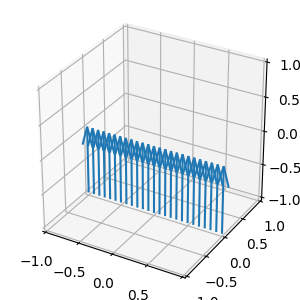

In [78]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.quiver(*rf.origins.T, *rf.dirs.T)
lim(ax)

**Ray factories can be added to each other:**

In [81]:
rf2 = rf + pt.BasicRF(0,np.linspace(-1,1,15),-.5,[(x,0,1) for x in np.linspace(-.5,.5,15)])

<IPython.core.display.Javascript object>


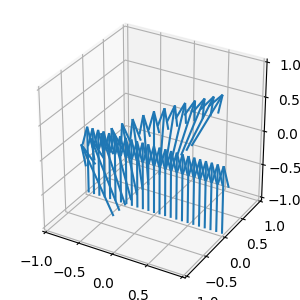

In [82]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.quiver(*rf2.origins.T, *rf2.dirs.T)
lim(ax)

**They can also be indexed like arrays**

In [83]:
rf3 = rf2[5:-6:3]

<IPython.core.display.Javascript object>


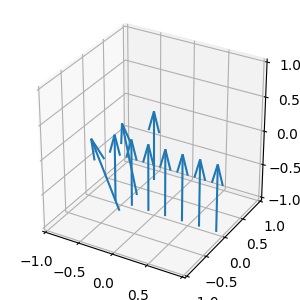

In [84]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.quiver(*rf3.origins.T, *rf3.dirs.T)
lim(ax)

**Currently the most important RF is HexagonalGaussianRF, mostly because I had the most success with getting it to display resonable results**

In [85]:
rf4 = pt.HexagonalGaussianRF([0,0,0], [0,0,1],.5,1,150,532,[-.2,0,-.2],.4)

<IPython.core.display.Javascript object>


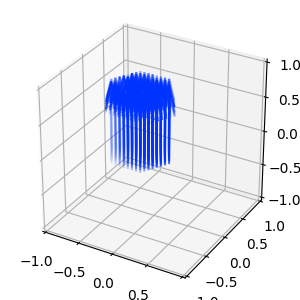

In [86]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
w_max = np.amax(rf4.weights)
ax.quiver(*rf4.origins.T, *rf4.dirs.T, colors=[(0,.2,1,w/w_max) for w in rf4.weights])
lim(ax)

**This has quite a few arguments by comparison, but it takes into account ray weights in a Gaussian beam, and can sample it at arbitrary points (set by `origin`). Note how on the graph above the rays become fainter away from [0,0]**

**A useful NOTE:** You can press `shift+tab` with a cursor inside a function to bring up a tooltip with its documetation. This can then be pinned at the bottom of the screen. This can be useful for things with as many arguments as some of the RayFactories.

# Tracer Objects
TracerObjects (TOs) are the things that interact with the rays in this tracer.

In [59]:
sphere = pt.Sphere([0,0,0], 1)

<IPython.core.display.Javascript object>


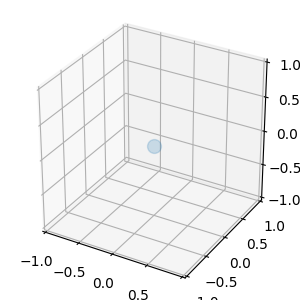

In [89]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
sphere.plot(ax)
lim(ax)

**Each TO has a plot method. The one for the sphere just shows a point unfortunately.**

In [51]:
p = pt.Surface([0,0,0],[0,1,1])

<IPython.core.display.Javascript object>


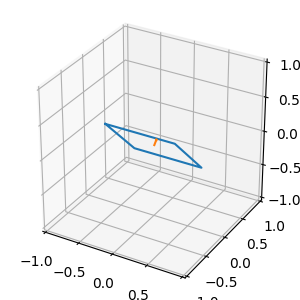

In [90]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
p.plot(ax)
lim(ax)

In [53]:
m = pt.SmoothMeshTO([0,0,0], "objs/ico-3.obj", .8)

<IPython.core.display.Javascript object>


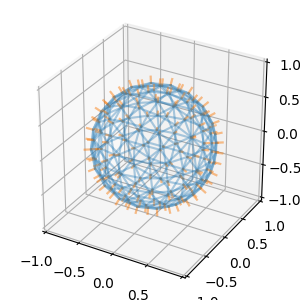

In [91]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
m.plot(ax)
lim(ax)

**Each TO allows you to inspect the momentum and angular momentum it has accumulated so far.** It will be 0 for the above ones.

**To get SI units, this needs to be multiplied by h (Planck's constant) * 1e9 (wavelength is stored in nm)**

In [55]:
m.momentum, s.ang_momentum

(array([0., 0., 0.]), array([0., 0., 0.]))

**Each TO can accept a set of standard arguments.** For more details, see the docstrings in `ptracer.py`.

In [58]:
pt.TracerObject(origin=[0,0,0], n_out=1., n_in=1., ang_origin=None, rot=(1,0,0,0), reflective=False, active=True)

# 3. Scene
The Scene is what runs the simulation. It takes in a single RF, and a list of TOs. **The first run may take a while as numba compiles and caches some functions.**

In [158]:
p = pt.Surface([0,0,0],[.2,.6,-1],n_in=1.5)
p2 = pt.Surface([0,0,.2],[-.2,-.6,1],n_in=1.5)

s = pt.Scene(rf, [p, p2])
# The number of steps after which the simulation stops can be adjusted
s.run(limit=5)
s.propagate(0.2)

<IPython.core.display.Javascript object>


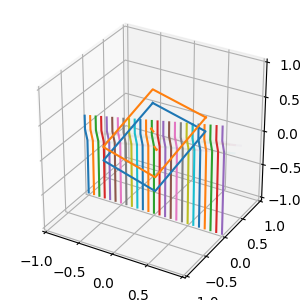

In [159]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
# Ray weights are shows by default, but this can be turned off to show all rays.
# For each ray, the last weight it has achieved will be shown throughout its path, resulting
# in possible artifacts in the display, but this doesn't impact calculations
s.plot(ax, show_weight=True)
lim(ax)

**Our plane has acquired some momentum!**

In [161]:
p.momentum, p.ang_momentum

(array([ 0.00343733,  0.01031198, -0.01718664]),
 array([-8.06085770e-02,  2.68695257e-02, -4.16404785e-16]))

**These can also be checked from the Scene - especially useful when there's more than one object.**

In [162]:
s.momentum, s.ang_momentum

(array([-0.00096238, -0.00288715,  0.00481192]),
 array([-7.05995782e-01,  2.35331927e-01,  4.16696164e-16]))

**Any combination of RF and TOs can be investigated in this way.**

For a more complex example - a hollow sphere in a Gaussian beam.

In [173]:
s1 = pt.Sphere([0,0,.2], .5, n_in=1.5)
s2 = pt.Sphere([0,0,.2], .45, n_out=1.5)

rf = pt.HexagonalGaussianRF([-1,0,0], [0,0,1], 1, 1, 100, 1e6, [0,0,-.72], .5)

s = pt.Scene(rf, [s1, s2])
s.run(limit=5)
# Move the rays without collisions along their path so we can see the direction they ended up with
s.propagate(.1)

<IPython.core.display.Javascript object>


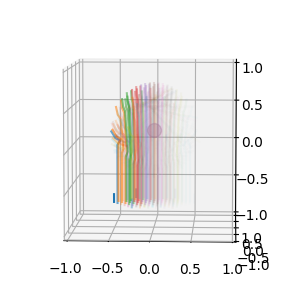

In [174]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
s.plot(ax, show_weight=True)
lim(ax)

In [176]:
# A net force pushing the shell out of the beam!
s.momentum

array([5.2784163e+13, 1.1712000e-02, 7.6973185e+13])

**A mesh**

In [188]:
m = pt.SmoothMeshTO([0,0,.2], "objs/torus.obj", .8, n_in=1.5, rot=quaternion(.2,(0,1,0)))

rf = pt.HexagonalGaussianRF([-1,0,0], [0,0,1], 1, 1, 100, 1e6, [0,0,-.72], .8)

s = pt.Scene(rf, [m])
s.run(limit=2)
# Move the rays without collisions along their path so we can see the direction they ended up with
s.propagate(.1)

<IPython.core.display.Javascript object>


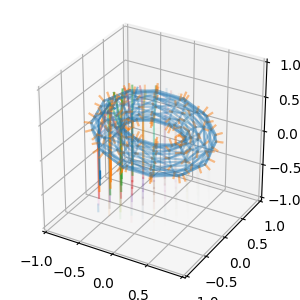

In [189]:
fig = plt.figure(figsize=(3,3), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
s.plot(ax, show_weight=True)
lim(ax)

In [190]:
s.momentum, s.ang_momentum

(array([-1.39595514e+14,  1.80191199e+13,  4.74172250e+14]),
 array([-1.30699382e+17,  2.05741789e+20, -1.15902415e+19]))